In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_validate
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

import sys
import os
import pydicom
import pickle

from PIL import Image

from torch import optim
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader

from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.gaussian_process import GaussianProcessClassifier

In [22]:
def train(network, data, epochs, learning_rate, l2=0):
    loss = nn.MSELoss()
    #SGD
    network.cuda()
    optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate, weight_decay=l2)
    train, test = train_test_split(data)
    train_loader = DataLoader(train, batch_size=50, shuffle=True)
    test_loader = DataLoader(test, batch_size=50, shuffle=True)
    res = 0
    try:
        for epoch in range(epochs):
            train_losses = []
            train_accuracies = []
            
            for X in train_loader:
                X = Variable(X)
                X = X.float()
                X = X.cuda()
                network.zero_grad()
                prediction = network(X)
                loss_batch = loss(prediction, X)
                loss_batch.backward()
                optimizer.step()
                train_losses.append(loss_batch.item())
                
                prediction = prediction.cpu()
                X = X.cpu()
                
                train_accuracies.append(np.absolute((prediction.data.numpy() - X.data.numpy())).sum()) 
            train_losses = np.mean(train_losses)
            train_accuracies = np.mean(train_accuracies)
            
            
            test_losses = []
            test_accuracies = []
            for X in test_loader:
                X = Variable(X)
                X = X.float()
                X = X.cuda()
                prediction = network(X)
                loss_batch = loss(prediction, X)
                test_losses.append(loss_batch.item())
                
                prediction = prediction.cpu()
                X = X.cpu()
                
                test_accuracies.append(np.absolute((prediction.data.numpy() - X.data.numpy())).sum())
            
            test_losses = np.mean(test_losses)
            test_accuracies = np.mean(test_accuracies)
            
            res = (train_losses, test_losses, train_accuracies, test_accuracies)
            sys.stdout.write('\rEpoch {0}... (Train/Test) MSE: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                        epoch, train_losses, test_losses,
                        train_accuracies, test_accuracies))
        
    except KeyboardInterrupt:
        pass
    network.cpu()
    return res

In [3]:
def check_models(X, y, metric='accuracy'):
    res = {'LogisticRegression': 0,
           'DecisionTree': 0,
           'GaussianNB': 0,
           'SVC': 0,
           'SGD': 0,
           'GaussianProcess': 0,
           'XGBoost': 0
          }
    #print metric
    X, y = shuffle(X, y)
    lg = LogisticRegression(solver='liblinear', multi_class='auto')
    cv = cross_validate(lg, X, y, cv=5, scoring=metric)
    res['LogisticRegression'] = np.mean(cv['test_score'])
    
    dt = DecisionTreeClassifier(criterion='gini')
    cv = cross_validate(dt, X, y, cv=5)
    res['DecisionTree'] = np.mean(cv['test_score'])
    
    bayes = GaussianNB()
    cv = cross_validate(bayes, X, y, cv=5, scoring=metric)
    res['GaussianNB'] = np.mean(cv['test_score'])
    
    svc = SVC(kernel='rbf', shrinking=True, probability=False, degree=3, gamma='auto')
    cv = cross_validate(svc, X, y, cv=5, scoring=metric)
    res['SVC'] = np.mean(cv['test_score'])
    
    sgd = SGDClassifier(tol=1e-3, max_iter=1000, loss='hinge')
    cv = cross_validate(sgd, X, y, cv=5, scoring=metric)
    res['SGD'] = np.mean(cv['test_score'])
    
    gp = GaussianProcessClassifier()
    cv = cross_validate(gp, X, y, cv=5, scoring=metric)
    res['GaussianProcess'] = np.mean(cv['test_score'])
    
    #gb = XGBClassifier(max_depth=10, n_estimators=20, booster='dart')
    #cv = cross_validate(gb, X, y, cv=10, scoring=metric)
    #res['XGBoost'] = np.mean(cv['test_score'])
    
    return res

In [4]:
class MyAutoencoder64(nn.Module):
    def __init__(self, n_comp=10):
        super(MyAutoencoder64, self).__init__()
        self.encoder = nn.Sequential(nn.Linear(4096, 500), nn.Sigmoid(), 
        nn.Linear(500, 64), nn.Sigmoid(), 
        nn.Linear(64, n_comp))
        self.decoder = nn.Sequential(nn.Linear(n_comp, 64), nn.Tanh(), 
        nn.Linear(64, 500), nn.Tanh(), 
        nn.Linear(500, 4096))
        
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    def encode(self, x):
        x = self.encoder(x)

        return x.data.numpy()

In [5]:
class MySparceAutoencoder64(nn.Module):
    def __init__(self, n_comp=10):
        super(MySparceAutoencoder64, self).__init__()
        self.n_comp = n_comp

        self.encoder = nn.Sequential(nn.Linear(4096, 1000), nn.Sigmoid(), 
        nn.Linear(1000, 500), nn.Sigmoid(), 
        nn.Linear(500, 100))
        self.decoder = nn.Sequential(nn.Linear(100, 500), nn.Tanh(), 
        nn.Linear(500, 1000), nn.Tanh(), 
        nn.Linear(1000, 4096))

    def forward(self, x):
        x = self.encoder(x)
        x[x < x.sort(dim=1, descending=True)[0][:,self.n_comp - 1].resize(len(x),1)] = 0
        x = self.decoder(x)
        return x

    def encode(self, x):
        x = self.encoder(x)
        x[x < x.sort(dim=1, descending=True)[0][:,self.n_comp - 1].resize(len(x),1)] = 0

        return x.data.numpy()

In [6]:
class MyDeepAutoencoder64(nn.Module):
    def __init__(self, n_comp=10):
        super(MyDeepAutoencoder64, self).__init__()
        self.n_comp = n_comp
        
        self.encoder = nn.Sequential(nn.Linear(4096, 2000), nn.Sigmoid(), 
        nn.Linear(2000, 1100), nn.Sigmoid(), 
        nn.Linear(1100, 500), nn.Sigmoid(), 
        nn.Linear(500, 300), nn.Sigmoid(), 
        nn.Linear(300, 100), nn.Sigmoid(), 
        nn.Linear(100, n_comp))
        self.decoder = nn.Sequential(nn.Linear(n_comp, 100), nn.Tanh(), 
        nn.Linear(100, 300), nn.Tanh(),
        nn.Linear(300, 500), nn.Tanh(),
        nn.Linear(500, 1100), nn.Tanh(),
        nn.Linear(1100, 2000), nn.Tanh(), 
        nn.Linear(2000, 4096))

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    def encode(self, x):
        x = self.encoder(x)

        return x.data.numpy()

In [7]:
class MyDeepSparceAutoencoder64(nn.Module):
    def __init__(self, n_comp=10):
        super(MyDeepSparceAutoencoder64, self).__init__()
        self.n_comp = n_comp

        self.encoder = nn.Sequential(nn.Linear(4096, 2000), nn.Sigmoid(), 
        nn.Linear(2000, 1100), nn.Sigmoid(), 
        nn.Linear(1100, 500), nn.Sigmoid(), 
        nn.Linear(500, 300), nn.Sigmoid(), 
        nn.Linear(300, 100))
        self.decoder = nn.Sequential( 
        nn.Linear(100, 300), nn.Tanh(),
        nn.Linear(300, 500), nn.Tanh(),
        nn.Linear(500, 1100), nn.Tanh(),
        nn.Linear(1100, 2000), nn.Tanh(), 
        nn.Linear(2000, 4096))

    def forward(self, x):
        x = self.encoder(x)
        x[x < x.sort(dim=1, descending=True)[0][:,self.n_comp - 1].resize(len(x),1)] = 0
        x = self.decoder(x)
        return x

    def encode(self, x):
        x = self.encoder(x)
        x[x < x.sort(dim=1, descending=True)[0][:,self.n_comp - 1].resize(len(x),1)] = 0

        return x.data.numpy()

In [8]:
class MyAutoencoder128(nn.Module):
    def __init__(self, n_comp=10):
        super(MyAutoencoder128, self).__init__()
        self.encoder = nn.Sequential(nn.Linear(16384, 5000), nn.Sigmoid(), 
        nn.Linear(5000, 1000),nn.Sigmoid(), 
        nn.Linear(1000, 300), nn.Sigmoid(), 
        nn.Linear(300, 60), nn.Sigmoid(), 
        nn.Linear(60, n_comp))
        self.decoder = nn.Sequential(nn.Linear(n_comp, 60), nn.Tanh(), 
        nn.Linear(60, 300), nn.Tanh(),
        nn.Linear(300, 1000), nn.Tanh(),
        nn.Linear(1000, 5000), nn.Tanh(), 
        nn.Linear(5000, 16384))
        
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    def encode(self, x):
        x = self.encoder(x)
        x[x < x.sort(dim=1, descending=True)[0][:,self.n_comp - 1].resize(len(x),1)] = 0

        return x.data.numpy()

In [9]:
class MySparceAutoencoder128(nn.Module):
    def __init__(self, n_comp=10):
        super(MySparceAutoencoder128, self).__init__()
        self.n_comp = n_comp
        self.encoder = nn.Sequential(nn.Linear(16384, 5000), nn.Sigmoid(), 
        nn.Linear(5000, 1000),nn.Sigmoid(), 
        nn.Linear(1000, 300), nn.Sigmoid(), 
        nn.Linear(300, 100))
        self.decoder = nn.Sequential(nn.Linear(100, 300), nn.Tanh(), 
        nn.Linear(300, 1000), nn.Tanh(),
        nn.Linear(1000, 5000), nn.Tanh(), 
        nn.Linear(5000, 16384))

    def forward(self, x):
        x = self.encoder(x)
        x[x < x.sort(dim=1, descending=True)[0][:,self.n_comp - 1].resize(len(x),1)] = 0
        x = self.decoder(x)

        return x

    def encode(self, x):
        x = self.encoder(x)
        x[x < x.sort(dim=1, descending=True)[0][:,self.n_comp - 1].resize(len(x),1)] = 0

        return x.data.numpy()

In [10]:
class MyDeepAutoencoder128(nn.Module):
    def __init__(self, n_comp=10):
        super(MyDeepAutoencoder128, self).__init__()
        self.n_comp = n_comp
        self.encoder = nn.Sequential(nn.Linear(16384, 10000), nn.Sigmoid(), 
        nn.Linear(10000, 6000),nn.Sigmoid(), 
        nn.Linear(6000, 2000), nn.Sigmoid(), 
        nn.Linear(2000, 800), nn.Sigmoid(), 
        nn.Linear(800, 300), nn.Sigmoid(), 
        nn.Linear(300, 100), nn.Sigmoid(), 
        nn.Linear(100, n_comp))
        self.decoder = nn.Sequential(nn.Linear(n_comp, 100), nn.Tanh(), 
        nn.Linear(100, 300), nn.Tanh(),
        nn.Linear(300, 800), nn.Tanh(),
        nn.Linear(800, 2000), nn.Tanh(),
        nn.Linear(2000, 6000), nn.Tanh(),
        nn.Linear(6000, 10000), nn.Tanh(), 
        nn.Linear(10000, 16384))

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)

        return x

    def encode(self, x):
        x = self.encoder(x)
        return x.data.numpy()

In [11]:
class MyDeepSparceAutoencoder128(nn.Module):
    def __init__(self, n_comp=10):
        super(MyDeepSparceAutoencoder128, self).__init__()
        self.n_comp = n_comp
        self.encoder = nn.Sequential(nn.Linear(16384, 10000), nn.Sigmoid(), 
        nn.Linear(10000, 6000),nn.Sigmoid(), 
        nn.Linear(6000, 2000), nn.Sigmoid(), 
        nn.Linear(2000, 800), nn.Sigmoid(), 
        nn.Linear(800, 300), nn.Sigmoid(), 
        nn.Linear(300, 100))
        self.decoder = nn.Sequential(nn.Linear(100, 300), nn.Tanh(),
        nn.Linear(300, 800), nn.Tanh(),
        nn.Linear(800, 2000), nn.Tanh(),
        nn.Linear(2000, 6000), nn.Tanh(),
        nn.Linear(6000, 10000), nn.Tanh(), 
        nn.Linear(10000, 16384))

    def forward(self, x):
        x = self.encoder(x)
        x[x < x.sort(dim=1, descending=True)[0][:,self.n_comp - 1].resize(len(x),1)] = 0
        x = self.decoder(x)
        
        return x

    def encode(self, x):
        x = self.encoder(x)
        x[x < x.sort(dim=1, descending=True)[0][:,self.n_comp - 1].resize(len(x),1)] = 0

        return x

In [12]:
class MyCAutoencoder(nn.Module):
    def __init__(self, n_comp=16):
        super(MyCAutoencoder, self).__init__()
        self.n_comp = n_comp
        self.ec1 = nn.Conv2d(1,2,(3,3),padding=1) 
        self.ep1 = nn.MaxPool2d(4, return_indices=True) 
        self.ec2 = nn.Conv2d(2,4,(3,3),padding=1)
        self.ep2 = nn.MaxPool2d(2, return_indices=True)
        self.ec3 = nn.Conv2d(4,n_comp,(3,3),padding=1)
        self.ep3 = nn.MaxPool2d(4, return_indices=True)
        self.el = nn.Linear(4,4)
        self.ep4 = nn.MaxPool2d(4, return_indices=True)
        
        self.dp4 = nn.MaxUnpool2d(4)
        self.dl = nn.Linear(4,4)
        self.dp3 = nn.MaxUnpool2d(4)
        self.dc3 = nn.Conv2d(n_comp,4,(3,3),padding=1) 
        self.dp2 = nn.MaxUnpool2d(2)
        self.dc2 = nn.Conv2d(4,2,(3,3),padding=1)
        self.dp1 = nn.MaxUnpool2d(4)
        self.dc1 = nn.Conv2d(2,1,(3,3),padding=1)
        
    def forward(self, x):
        relu = nn.ReLU()
        #encode
        x = self.ec1(x)
        x, i1 = self.ep1(x)
        x = relu(x)
        x = self.ec2(x)
        x, i2 = self.ep2(x)
        x = relu(x)
        x = self.ec3(x)
        x, i3 = self.ep3(x)
        x = relu(x)
        x = self.el(x)
        x, i4 = self.ep4(x)
        
        x = self.dp4(x, i4)
        x = self.dl(x)
        x = relu(x)
        x = self.dp3(x, i3)
        x = self.dc3(x)
        x = relu(x)
        x = self.dp2(x, i2)
        x = self.dc2(x)
        x = relu(x)
        x = self.dp1(x, i1)
        x = self.dc1(x)

        
        return x
    def encode(self, x):
        relu = nn.ReLU()
        
        x = self.ec1(x)
        x, i1 = self.ep1(x)
        x = relu(x)
        x = self.ec2(x)
        x, i2 = self.ep2(x)
        x = relu(x)
        x = self.ec3(x)
        x, i3 = self.ep3(x)
        x = relu(x)
        x = self.el(x)
        x, i4 = self.ep4(x)
        
        return x.data.numpy().reshape(-1, self.n_comp)

In [49]:
N = 200
#d2models64 = [MyAutoencoder64, MySparceAutoencoder64, MyDeepAutoencoder64, MyDeepSparceAutoencoder64]
#d2models128 = [MyAutoencoder128, MySparceAutoencoder128, MyDeepAutoencoder128, MyDeepSparceAutoencoder128]
res = open('out.txt', 'w')
with open('y.pickle', 'rb') as f:
    y = pickle.load(f)
with open('other.pickle', 'rb') as f:
    other = pickle.load(f)

In [58]:
np.array(y).sum() / len(y)

0.8790661650807701

In [38]:
res = open('out.txt', 'w')

In [39]:

with open('d2data64.pickle', 'rb') as f:
    d2data64 = pickle.load(f)
print(d2data64.shape)

for i in range(10, 17):
    for model in d2models64:
        currmodel = model(i)
        train_loss, test_loss, train_ac, test_ac = train(currmodel, d2data64, N, 0.001)
        res.write('*' * 20 + '\n')
        res.write(str(type(currmodel)) + str(i) + '\n')
        res.write('(Train/Test) MSE: {0:.3f}/{1:.3f}\tAccuracy: {2:.3f}/{3:.3f}\n'.format(
                    train_loss, test_loss,
                    train_ac, test_ac))
    
        X1 = currmodel.encode(Variable(torch.Tensor(d2data64)))
        X1 = pd.DataFrame(X1)
        data = pd.concat([X1, other], axis=1)
        f1 = check_models(data, y, metric='f1')

        res.write(str(f1) + '\n')

del d2data64
gc.collect()






(9038, 4096)
Epoch 199... (Train/Test) MSE: 0.009/0.009	Accuracy: 10885.715/10822.426

D:\programs\anaconda\lib\site-packages\torch\tensor.py:287: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


Epoch 199... (Train/Test) MSE: 0.029/0.030	Accuracy: 23811.740/25071.557

D:\programs\anaconda\lib\site-packages\torch\tensor.py:287: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


Epoch 199... (Train/Test) MSE: 0.009/0.009	Accuracy: 10809.850/10683.635

D:\programs\anaconda\lib\site-packages\torch\tensor.py:287: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


Epoch 199... (Train/Test) MSE: 0.030/0.029	Accuracy: 24534.979/23494.062

D:\programs\anaconda\lib\site-packages\torch\tensor.py:287: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


Epoch 199... (Train/Test) MSE: 0.009/0.009	Accuracy: 10687.960/10775.550

D:\programs\anaconda\lib\site-packages\torch\tensor.py:287: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


Epoch 199... (Train/Test) MSE: 0.021/0.021	Accuracy: 17829.271/17372.400

D:\programs\anaconda\lib\site-packages\torch\tensor.py:287: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


Epoch 199... (Train/Test) MSE: 0.009/0.009	Accuracy: 10653.196/10620.190

D:\programs\anaconda\lib\site-packages\torch\tensor.py:287: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


Epoch 199... (Train/Test) MSE: 0.029/0.029	Accuracy: 23890.125/23669.736

D:\programs\anaconda\lib\site-packages\torch\tensor.py:287: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


Epoch 199... (Train/Test) MSE: 0.009/0.009	Accuracy: 10755.103/10708.17375

D:\programs\anaconda\lib\site-packages\torch\tensor.py:287: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


Epoch 199... (Train/Test) MSE: 0.021/0.021	Accuracy: 17698.867/17810.520

D:\programs\anaconda\lib\site-packages\torch\tensor.py:287: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


Epoch 199... (Train/Test) MSE: 0.009/0.009	Accuracy: 10853.759/10778.4639

D:\programs\anaconda\lib\site-packages\torch\tensor.py:287: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


Epoch 199... (Train/Test) MSE: 0.029/0.031	Accuracy: 24039.426/24506.869

D:\programs\anaconda\lib\site-packages\torch\tensor.py:287: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


Epoch 199... (Train/Test) MSE: 0.009/0.009	Accuracy: 10752.287/10610.707

D:\programs\anaconda\lib\site-packages\torch\tensor.py:287: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


Epoch 199... (Train/Test) MSE: 0.029/0.031	Accuracy: 24084.791/23983.307

D:\programs\anaconda\lib\site-packages\torch\tensor.py:287: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


Epoch 199... (Train/Test) MSE: 0.021/0.021	Accuracy: 17811.312/17241.809

NameError: name 'gc' is not defined

In [ ]:
with open('d2data128.pickle', 'rb') as f:
    d2data128 = pickle.load(f)

for i in range(10, 17):
    for model in d2models128:
        currmodel = model(i)
        train_loss, test_loss, train_ac, test_ac = train(model, d2data128, N, 0.001)
        res.write('*' * 20 + '\n')
        res.write(str(type(currmodel)) + str(i) + '\n')
        res.write('(Train/Test) MSE: {0:.3f}/{1:.3f}\tAccuracy: {2:.3f}/{3:.3f}\n'.format(
                    train_loss, test_loss,
                    train_ac, test_ac))
    
        X1 = currmodel.encode(Variable(torch.Tensor(d2data64)))
        X1 = pd.DataFrame(X1)
        data = pd.concat([X1, other], axis=1)
        f1 = check_models(data, y, metric='f1')

        res.write(str(f1) + '\n')

del d2data64
gc.collect()

In [44]:
with open('d3data128.pickle', 'rb') as f:
    d3data128 = pickle.load(f)

for i in range(10, 17):
    currmodel = MyCAutoencoder(i)
    train_loss, test_loss, train_ac, test_ac = train(currmodel, d3data128, N, 0.001)
    res.write('*' * 20 + '\n')
    res.write(str(type(currmodel)) + str(i) + '\n')
    res.write('(Train/Test) MSE: {0:.3f}/{1:.3f}\tAccuracy: {2:.3f}/{3:.3f}\n'.format(
                train_loss, test_loss,
                train_ac, test_ac))

    X1 = currmodel.encode(Variable(torch.Tensor(d3data128)))
    X1 = pd.DataFrame(X1)
    data = pd.concat([X1, other], axis=1)
    f1 = check_models(data, y, metric='f1')
    res.write(str(f1) + '\n')
    break
res.close()

Epoch 199... (Train/Test) MSE: 0.032/0.032	Accuracy: 118616.531/116904.719

ValueError: Must pass 2-d input

In [51]:
X1 = pd.DataFrame(X1.reshape(-1, 10))
data = pd.concat([X1, other], axis=1)
f1 = check_models(data, y, metric='f1')
res.write(str(f1) + '\n')

175

In [52]:
f1

{'LogisticRegression': 0.9356416602524019,
 'DecisionTree': 1.0,
 'GaussianNB': 0.9175548323112119,
 'SVC': 1.0,
 'SGD': 0.8965541913145783,
 'GaussianProcess': 1.0,
 'XGBoost': 0}

In [38]:
f = open('out.txt')
cur = 0
result = {}
for l in f:
    if cur == 0:
        pass
    elif cur == 1:
        model = (l[7:].split('>')[0], int(l[7:].split('>')[1]))
    elif cur == 2:
        pass
    elif cur == 3:
        res = {}
        l = l[1:-2]
        for i in l.split(','):
            res[i.split(':')[0]] = float(i.split(':')[1])
        for a, b in res.items():
            if 'XGBoost' in a:
                continue
            try:
                result[model[0]][a].append(b)
            except:
                try:
                    result[model[0]][a] = []
                    result[model[0]][a].append(b)
                except:
                    result[model[0]] = {}
                    result[model[0]][a] = []
                    result[model[0]][a].append(b)
    cur = (cur + 1) % 4
print(result)

{"'__main__.MyAutoencoder64'": {"'LogisticRegression'": [0.9347364994687926, 0.9361354797295549, 0.9359968205116143, 0.9350156658815901, 0.9359989608592658, 0.9352741398504136, 0.9345006188998815], " 'DecisionTree'": [0.9981192223978494, 0.9990052801282404, 0.9987829400241777, 0.997676255054467, 0.9982299646397795, 0.9978978606868927, 0.9955738712784447], " 'GaussianNB'": [0.8813056369157524, 0.8743307972072601, 0.8674407335393368, 0.8505178298254339, 0.8627962767673953, 0.7876586212822984, 0.8231459642207973], " 'SVC'": [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], " 'SGD'": [0.9034260418115647, 0.9069351762281682, 0.9241600236128911, 0.9243942798626554, 0.8787837628759668, 0.8780296710557849, 0.8760187902491967], " 'GaussianProcess'": [0.9999370673379484, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]}, "'__main__.MySparceAutoencoder64'": {"'LogisticRegression'": [0.9358621745778384, 0.9355161613142089, 0.9356416602524019, 0.9356416602524019, 0.935516244162802, 0.9356416602524019, 0.9356416602524019], " 'Deci

In [26]:
import matplotlib.pyplot as plt

%matplotlib inline

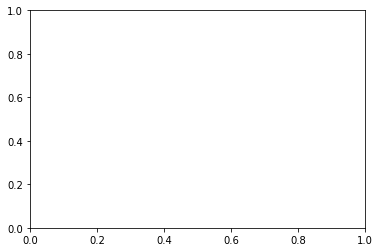

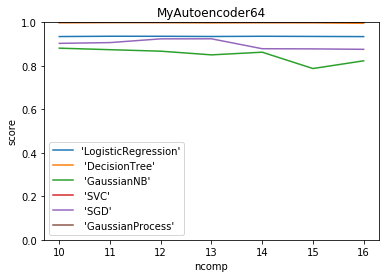

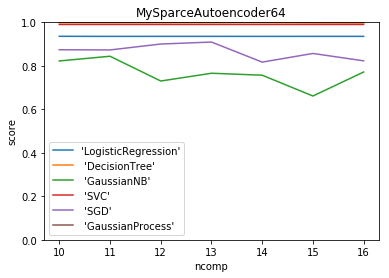

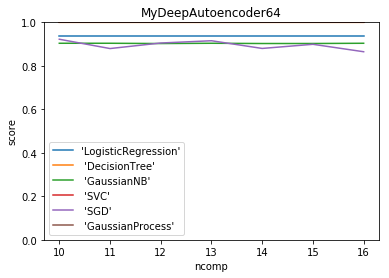

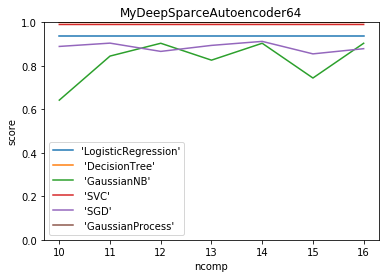

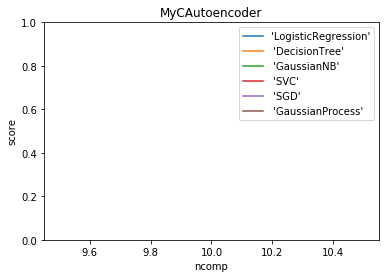

In [47]:
fig, axes = plt.subplots()
for models in result.items():
    fig, axes = plt.subplots()
    for model in models[1].items():
        axes.set_title(models[0][10:-1])
        axes.set_ylim(bottom=0.)
        axes.plot(range(10, len(model[1]) + 10), model[1], label=model[0])
        axes.set_ylabel(u'score')
        axes.set_xlabel(u'ncomp')
        axes.legend()